# 1. Imports & functions

#### 1.1 Imports

In [1]:
# Data Wrangling
import pandas as pd
import numpy as np 

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#### 1.2 Functions

In [2]:
# Create New Columns for identifying different guest types
def map_guest_type (row):
    if row["adults"] == 1 and row["children"] == 0 and row["babies"] == 0:
        return "Single"
    elif row["adults"] == 2 and row["children"] == 0 and row["babies"] == 0:
        return "Couple"
    elif (row["adults"] == 2 or row["adults"] == 1) and (row["children"] > 0 or row["babies"] > 0):
        return "Family"
    elif row["adults"] > 2:
        return "Group"
    else:
        return "Other"
        
        

# 2. Load Data

In [3]:
pwd

'C:\\Users\\andre\\Documents\\IRONHACK\\UNIT_3\\Project'

In [4]:
!dir data\\raw

 Datentr„ger in Laufwerk C: ist Windows
 Volumeseriennummer: 20BD-6958

 Verzeichnis von C:\Users\andre\Documents\IRONHACK\UNIT_3\Project\data\raw

05.03.2024  18:21    <DIR>          .
05.03.2024  18:21    <DIR>          ..
05.03.2024  18:21        16.855.599 hotel_bookings.csv
               1 Datei(en),     16.855.599 Bytes
               2 Verzeichnis(se), 704.148.451.328 Bytes frei


In [5]:
df = pd.read_csv("./data/raw/hotel_bookings.csv")

# 2. DATA OVERVIEW

In [6]:
pd.options.display.max_columns = None # show all columns
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [7]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [8]:
df.shape

(119390, 32)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [10]:
df["reserved_room_type"].unique()

array(['C', 'A', 'D', 'E', 'G', 'F', 'H', 'L', 'P', 'B'], dtype=object)

#### 2.1 Overview - Missing Values

In [11]:
missing_values = df.isna().sum()
missing_values = missing_values[missing_values > 0]
missing_values

children         4
country        488
agent        16340
company     112593
dtype: int64

#### 2.2 Overview - Unique Values

In [12]:
df.nunique()

hotel                                2
is_canceled                          2
lead_time                          479
arrival_date_year                    3
arrival_date_month                  12
arrival_date_week_number            53
arrival_date_day_of_month           31
stays_in_weekend_nights             17
stays_in_week_nights                35
adults                              14
children                             5
babies                               5
meal                                 5
country                            177
market_segment                       8
distribution_channel                 5
is_repeated_guest                    2
previous_cancellations              15
previous_bookings_not_canceled      73
reserved_room_type                  10
assigned_room_type                  12
booking_changes                     21
deposit_type                         3
agent                              333
company                            352
days_in_waiting_list     

#### 2.3 Overview _ Primary visualizations

In [13]:
df_viz = df.copy()

In [14]:
df_viz.fillna(0, inplace=True)

In [15]:
df_viz["guest_type"] = df_viz.apply(map_guest_type, axis=1)

In [16]:
guest_type_count = df_viz['guest_type'].value_counts()
guest_type_count

guest_type
Couple    81560
Single    22577
Family     8570
Group      6280
Other       403
Name: count, dtype: int64

In [17]:
guest_type_count.index

Index(['Couple', 'Single', 'Family', 'Group', 'Other'], dtype='object', name='guest_type')

<function matplotlib.pyplot.show(close=None, block=None)>

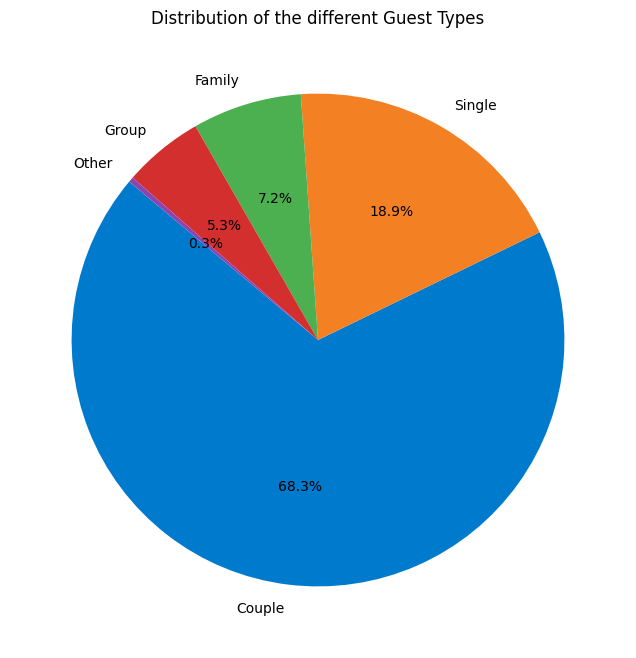

In [18]:
# Pie Plot (https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pie.html)
colors = ['#007acc', '#f48024', '#4caf50', '#d32f2f', '#8e44ad'] # sliceshttps://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_features.html#sphx-glr-gallery-pie-and-polar-charts-pie-features-py

plt.figure(figsize=(8, 8))
plt.pie(guest_type_count, labels=guest_type_count.index, colors=colors, autopct='%1.1f%%', startangle=140) # percentage using autopct: https://stackoverflow.com/questions/6170246/how-do-i-use-matplotlib-autopct
plt.title("Distribution of the different Guest Types")

plt.savefig('./resources/pie_guest_type.png') 

plt.show

# 3. DESCRIPTIVE ANALYSIS 

In [19]:
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


# 4. DATA CLEANING

#### 4.1 DATA CLEANING - DROP COLUMNS
Drop Columns not required for analysis

In [20]:
df_clean = df.copy()

In [21]:
df_clean.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [22]:
# Columns to drop

columns_drop_list = ['arrival_date_year',
                    'arrival_date_month',
                    'arrival_date_day_of_month',
                    'stays_in_weekend_nights',
                     'stays_in_week_nights',
                     'country',
                     'distribution_channel' , 
                     'distribution_channel' ,
                     'is_repeated_guest' ,
                     'previous_cancellations' ,
                     'previous_bookings_not_canceled' ,
                     'assigned_room_type' ,
                     'booking_changes' ,
                     'deposit_type' ,
                     'agent' ,
                     'company' ,
                     'days_in_waiting_list' ,
                     'customer_type' ,
                     'required_car_parking_spaces' ,
                     'total_of_special_requests' ,
                     'reservation_status' ,
                     'reservation_status_date']

In [23]:
# Drop Columns
df_clean.drop(columns=columns_drop_list, inplace=True)

In [24]:
display("n-col-original: ", df.shape[1], "n-col-drop: ", df_clean.shape[1] )

'n-col-original: '

32

'n-col-drop: '

11

In [25]:
df_clean.head()

,hotel,is_canceled,lead_time,arrival_date_week_number,adults,children,babies,meal,market_segment,reserved_room_type,adr
0,Resort Hotel,0,342,27,2,0.0,0,BB,Direct,C,0.0
1,Resort Hotel,0,737,27,2,0.0,0,BB,Direct,C,0.0
2,Resort Hotel,0,7,27,1,0.0,0,BB,Direct,A,75.0
3,Resort Hotel,0,13,27,1,0.0,0,BB,Corporate,A,75.0
4,Resort Hotel,0,14,27,2,0.0,0,BB,Online TA,A,98.0


#### 4.1 DATA CLEANING - Handle Missing Values
Deal with mssing values

In [26]:
missing_values = df_clean.isna().sum()
missing_values = missing_values[missing_values > 0]
missing_values

children    4
dtype: int64

In [27]:
df_clean["adults"].unique()

array([ 2,  1,  3,  4, 40, 26, 50, 27, 55,  0, 20,  6,  5, 10],
      dtype=int64)

<b style="color:red">Missing Value Strategy</b>
- Get the rows where adults equals two (identify potential parents)
- get mode of children for the parent group
- Replace missing values in children column with the mode calculated for the parent group

In [28]:
# Check values -> one could already replaces the missing values with 0.0 (why is inter dsplayed as float?)
df_clean[df_clean["adults"] >= 2]["children"].value_counts()

children
0.0     88029
1.0      4578
2.0      3287
3.0        61
10.0        1
Name: count, dtype: int64

In [29]:
# get mode
adult_children_mode = df_clean[df_clean["adults"] >= 2].groupby("adults")["children"].agg(lambda x: x.mode()[0])
adult_children_mode

adults
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
10    0.0
20    0.0
26    0.0
27    0.0
40    0.0
50    0.0
55    0.0
Name: children, dtype: float64

In [30]:
# map the value of missing values in df_clean children where it maps to the adults columnd in adult_children_mode
missing_children_replace = pd.merge(df_clean[df_clean["children"].isna()], adult_children_mode, left_on="adults", right_index=True, suffixes=('', '_mode'))


In [31]:
missing_children_replace

,hotel,is_canceled,lead_time,arrival_date_week_number,adults,children,babies,meal,market_segment,reserved_room_type,adr,children_mode
40600,City Hotel,1,2,32,2,NaN,0,BB,Undefined,B,12.0,0.0
40667,City Hotel,1,1,32,2,NaN,0,BB,Direct,B,12.0,0.0
40679,City Hotel,1,1,32,3,NaN,0,BB,Undefined,B,18.0,0.0
41160,City Hotel,1,8,33,2,NaN,0,BB,Online TA,B,76.5,0.0


In [32]:
df_clean.loc[df_clean[df_clean["children"].isna()].index, "children"] = missing_children_replace["children_mode"]

In [33]:
df_clean.isna().sum()

hotel                       0
is_canceled                 0
lead_time                   0
arrival_date_week_number    0
adults                      0
children                    0
babies                      0
meal                        0
market_segment              0
reserved_room_type          0
adr                         0
dtype: int64

#### 4.2 ADD GUEST TYPE COLUMN column
Add guest_type column to identify different guest types (e.g. single, family, etc.)

In [34]:
df_clean["guest_type"] = df_clean.apply(map_guest_type, axis=1)

In [35]:
df_clean["guest_type"].value_counts()

guest_type
Couple    81560
Single    22577
Family     8570
Group      6280
Other       403
Name: count, dtype: int64

In [36]:
display("n-col-original: ", df.shape[1], "n-col-drop: ", df_clean.shape[1] )

'n-col-original: '

32

'n-col-drop: '

12

#### 4.3 WRITE CLEANED DATASET TO FOLDER

In [37]:
df_clean.to_csv('./data/cleaned/hotel_bookings_cleaned.csv')

# 5.DATA INSIGHTS

In [38]:
df_in = df_clean.copy()

In [39]:
df_in.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_week_number',
       'adults', 'children', 'babies', 'meal', 'market_segment',
       'reserved_room_type', 'adr', 'guest_type'],
      dtype='object')

#### 5.2 Average Daily Rate By Customer

Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights

In [40]:
adr_guest_type = df_in.groupby("guest_type")["adr"].mean()
adr_guest_type

guest_type
Couple     98.022416
Family    153.391779
Group     157.195635
Other      49.584814
Single     81.550715
Name: adr, dtype: float64

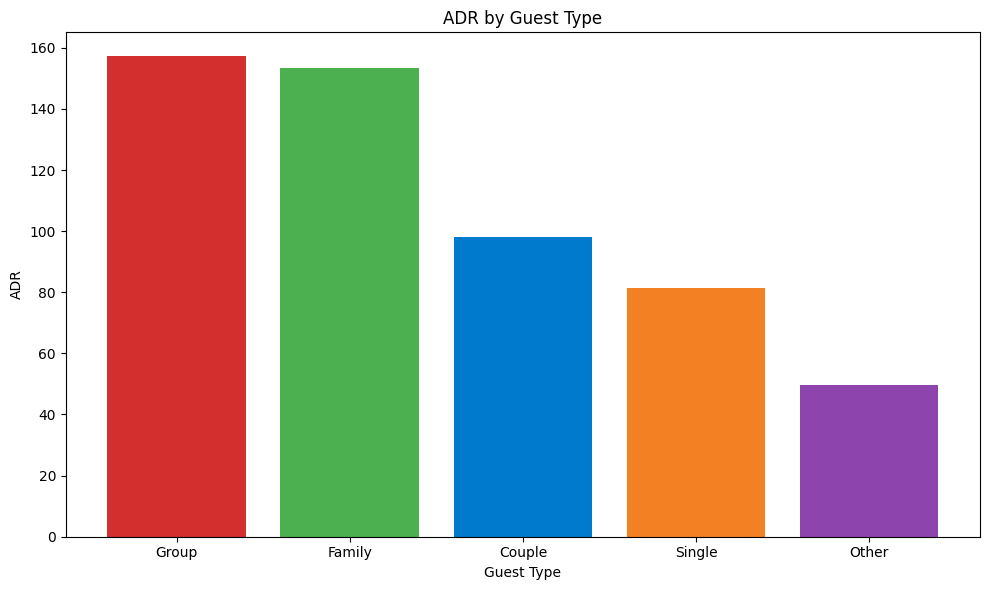

In [41]:
# Visualize ADR by guest type
colors = {"Couple": "#007acc", 
          "Single": "#f48024", 
          "Family": "#4caf50", 
          "Group": "#d32f2f", 
          "Other": "#8e44ad"}

# Sort Values descending
adr_guest_type_sorted = adr_guest_type.sort_values(ascending=False)

# Create Dataframe to be able to map the colors to the sorted values
adr_guest_type_sorted = adr_guest_type_sorted.to_frame().reset_index()
adr_guest_type_sorted['color'] = adr_guest_type_sorted["guest_type"].map(colors)

# Create Bar Plot
plt.figure(figsize=(10,6))
plt.bar(adr_guest_type_sorted["guest_type"], adr_guest_type_sorted["adr"], color=adr_guest_type_sorted["color"])


plt.title('ADR by Guest Type')
plt.xlabel("Guest Type")
plt.ylabel("ADR")

plt.tight_layout()

plt.savefig('./resources/adr_by_guest.png') # Save as PNG Image to resources

plt.show() # Show Graph

<b style="color:green"> ADR BY Guest Type - Findings</b></br>

- We see differences in the ADR between the different groups
      
- **Families && Groups**:
    - Higher ADR values compared to others -> Willing to spend more
    - Due to larger group size or preferences for more costly accomodations


- **Couples, Singles and Others**:
    - Have a lower ADR with Singles having the lowest ADR
    - Singles may tend to more budget-friendly accomodations
    - Others define an unkown group with a significant ADR 




<b style="color:green"> ADR - Reommendations</b></br>

- **Tailored Offerings**: Develop tailored offerings for the different groups specifically for the "Group" and "Family" types to gain from their willingnes to spend more
- **Price Optimization**: E.g. Offer special pricing for "Singles" or target these groups for sales purposes
- **Further Analysis**: Gather further analysis on why the different guest types have different ADRs 



#### 5.1 Room type preferences and meal choices

In [42]:
# Room Types
df_in["reserved_room_type"].unique()

array(['C', 'A', 'D', 'E', 'G', 'F', 'H', 'L', 'P', 'B'], dtype=object)

In [43]:
df_in["meal"].unique()

array(['BB', 'FB', 'HB', 'SC', 'Undefined'], dtype=object)

**Abbreviations** 

<a href="https://support.travelrepublic.co.uk/Before-I-Book/BIB-Accommodation/1035827372/What-does-the-board-basis-mean.htm">Hotel Meals Explained</a>

- **O** (Room Only): No meals are included.
- **SC** (Self Catering): No meals are included; however, your accommodation will be provided with catering facilities for you to cook light meals.
- **BB** (Bed and Breakfast): Breakfast is included.
- **HB** (Half Board): Breakfast and evening meals are included. In some cases, you can choose to receive lunch instead of breakfast – the hotel will confirm this on arrival.
- **FB** (Full Board): Breakfast, lunch and evening meals are included.

In [44]:
room_type_pref = df_in.groupby("guest_type")['reserved_room_type'].value_counts().unstack() # see usntack: 2.3_combining_structuring_data
room_type_pref

reserved_room_type,A,B,C,D,E,F,G,H,L,P
guest_type,,,,,,,,,,
Couple,61196.0,735.0,167.0,13064.0,4886.0,1049.0,411.0,48.0,4.0,NaN
Family,3328.0,131.0,673.0,871.0,480.0,1600.0,1356.0,131.0,NaN,NaN
Group,1355.0,8.0,73.0,3512.0,534.0,138.0,242.0,417.0,1.0,NaN
Other,131.0,211.0,1.0,23.0,17.0,5.0,3.0,NaN,NaN,12.0
Single,19984.0,33.0,18.0,1731.0,618.0,105.0,82.0,5.0,1.0,NaN


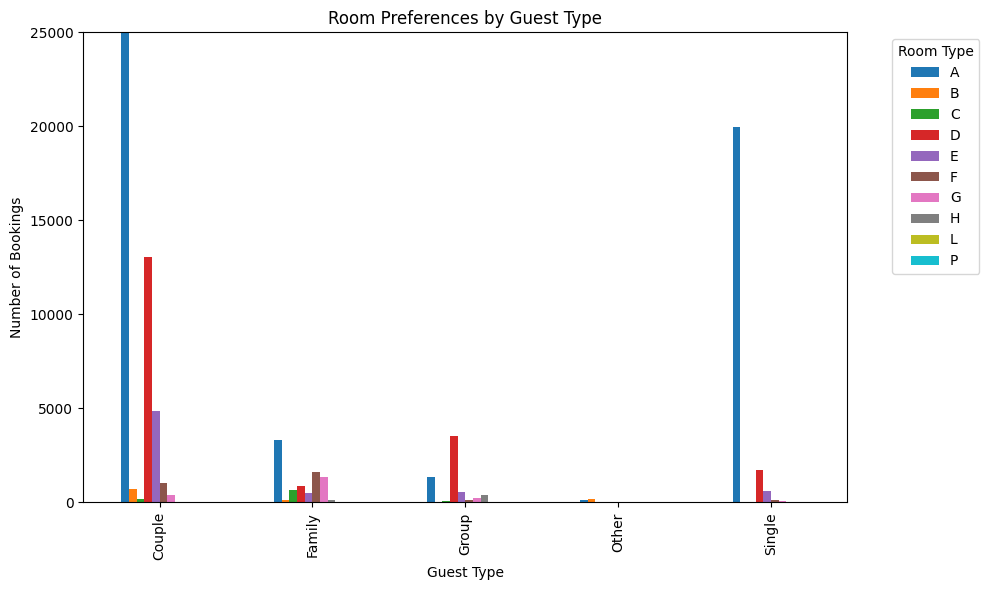

In [45]:
# Visualize room type preference  by guest type

room_type_pref.plot(kind='bar', figsize=(10, 6)) # https://stackoverflow.com/questions/11927715/how-to-give-a-pandas-matplotlib-bar-graph-custom-colors
plt.title('Room Preferences by Guest Type')
plt.xlabel("Guest Type")
plt.ylabel("Number of Bookings")
plt.legend(title='Room Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust y-axis to better dispaly the lower value bars
plt.ylim(0, 25000)

plt.tight_layout()

plt.savefig('./resources/room_type_pref.png') # Save as PNG Image to resources

plt.show() # Show Graph

<b style="color:green"> Room Type Preferences - Findings</b></br>

- **Couples**:
    - Room Type A is the most preferred among couples, with significantly higher number of bookings compared to other room types.
    - Only few bookings for room types "H" and "L"
      
- **Families**:
    - Room Type A is the most preferred among families, but not as striking. Followed by "F" and "G"
    - There are als few bookings for room types "H" and "L"
      
 - **Groups**:
    - Room Type D is the most preferred among Groups, but not as striking. Followed by "A".
        - The other room types are insignificant compared to the others

- **Others**:
    - Rather an insignifcant group -> re-allocate?
 
- **Singles**:
    - Room Type A is the most preferred among Groups, with significantly higher number of bookings compared to other room types.
    - Followed by "D".
    - The other room types are insignificant compared to the others




<b style="color:green"> Room Type Preferences - Reommendations</b></br>

- **Optimize Room Allocation**: Focus availability of preferred room types
- **Include Special Promotions**: Offer special promotions or discounts for less popular room types
- **Feedback**: Include further investigations on why certain groups prefer certain room types



In [46]:
meal_pref = df_in.groupby("guest_type")["meal"].value_counts().unstack()
meal_pref

meal,BB,FB,HB,SC,Undefined
guest_type,,,,,
Couple,60567.0,603.0,10736.0,8834.0,820.0
Family,6961.0,82.0,1281.0,189.0,57.0
Group,5385.0,41.0,724.0,87.0,43.0
Other,290.0,NaN,9.0,104.0,NaN
Single,19107.0,72.0,1713.0,1436.0,249.0


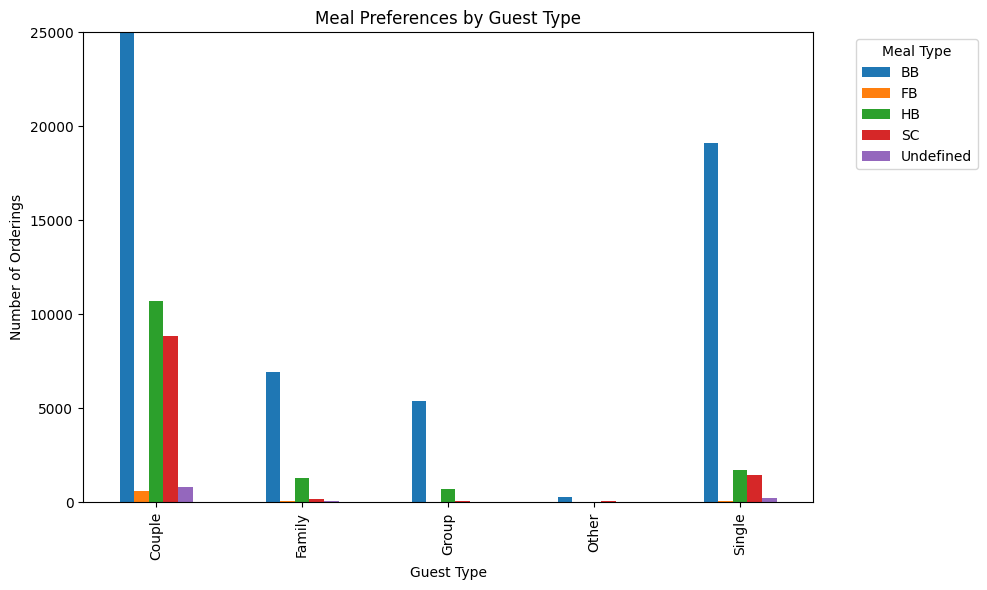

In [47]:
# Visualize meal type preference by guest type

meal_pref.plot(kind='bar', figsize=(10, 6)) # https://stackoverflow.com/questions/11927715/how-to-give-a-pandas-matplotlib-bar-graph-custom-colors
plt.title('Meal Preferences by Guest Type')
plt.xlabel("Guest Type")
plt.ylabel("Number of Orderings")
plt.legend(title='Meal Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust y-axis to better dispaly the lower value bars
plt.ylim(0, 25000)

plt.tight_layout()

plt.savefig('./resources/meal_type_pref.png') # Save as PNG Image to resources

plt.show() # Show Graph

<b style="color:green"> Meal Type Preferences - Findings</b></br>

- **Bed and Breakfast (BB)**:
    - Popular among all guest types, with a significant number of bookings for couples and singles.
    - A meal option included seems to be preffered as HB (half )
      
- **Half Board (HB) and Self-Catering (SC)**:
    - Couples show a preference for these meal type, with a significant number of bookings
    - Relativle insignificant for other guest types
      
 - **Others**:
    - Other meal types are less interesing



<b style="color:green"> Meal Type Preferences - Reommendations</b></br>

- **Customization**: Customize meal options or allow for customization options for meal packages
- **Promote Meal Packages**: Promote meal packages such as HB or FB to increase revenue
- **Feedback**: Include further investigations on why certain groups prefer certain meal types


In [48]:
pd.options.display.max_columns = None # show all columns
df_clean[df_clean["guest_type"]=="Other"]

,hotel,is_canceled,lead_time,arrival_date_week_number,adults,children,babies,meal,market_segment,reserved_room_type,adr,guest_type
2224,Resort Hotel,0,1,41,0,0.0,0,SC,Corporate,A,0.00,Other
2409,Resort Hotel,0,0,42,0,0.0,0,SC,Corporate,A,0.00,Other
3181,Resort Hotel,0,36,47,0,0.0,0,SC,Groups,A,0.00,Other
3684,Resort Hotel,0,165,53,0,0.0,0,SC,Groups,A,0.00,Other
3708,Resort Hotel,0,165,53,0,0.0,0,SC,Groups,A,0.00,Other
...,...,...,...,...,...,...,...,...,...,...,...,...
117204,City Hotel,0,296,30,0,2.0,0,BB,Online TA,B,98.85,Other
117274,City Hotel,0,276,31,0,2.0,0,BB,Online TA,B,93.64,Other
117303,City Hotel,0,291,30,0,2.0,0,BB,Online TA,B,98.85,Other
117453,City Hotel,0,159,31,0,2.0,0,SC,Online TA,A,121.88,Other


In [49]:
pd.options.display.max_columns = None # show all columns
df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07


In [50]:
df.shape

(119390, 32)

In [51]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [52]:
df_clean["children"].value_counts()

children
0.0     110800
1.0       4861
2.0       3652
3.0         76
10.0         1
Name: count, dtype: int64